# Dependencies

- Discussion [thread](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198744)
- Reference: [How To Create TFRecords](https://www.kaggle.com/cdeotte/how-to-create-tfrecords)

In [1]:
import re, math, os, cv2, random, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

In [2]:
os.mkdir('/kaggle/working/train/')
!cp -r /kaggle/input/cassava-leaf-disease-classification/train_images/* train # move data to "train" folder

### Find duplicates

In [3]:
import glob, torch, imagehash
from tqdm.auto import tqdm
from PIL import Image


IMAGES_DIR = '/kaggle/working/train/'

funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(glob.glob(IMAGES_DIR + '*.jpg')):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)
hashes_all = torch.Tensor(hashes_all.astype(int))

In [4]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).numpy()/256 for i in range(hashes_all.shape[0])])

indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
duplicate_image_ids = sorted(list(dups))
print('found %d duplicates' % len(duplicate_image_ids))

found 2 duplicates


In [5]:
# Remove duplicates from external data
imgs_to_remove = [x[1] for x in duplicate_image_ids]
remove_pd = []
for image in imgs_to_remove:
    remove_pd.append(image)        

In [6]:
!rm -r /kaggle/working/train/ # delete image files

# Auxiliar functions

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'target': tf.io.FixedLenFeature([], tf.int64), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    target = example['target']
    name = example['image_name']
    return image, target, name

def load_dataset(filenames, HEIGHT, WIDTH, CHANNELS=3):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        image, label, name = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(image[0])
        plt.title(f"{label[0]}: {name[0].numpy().decode('utf-8')}", fontsize=12)
    plt.show()

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Create TF Records
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, target, image_name):
  feature = {
      'image': _bytes_feature(image),
      'target': _int64_feature(target),
      'image_name': _bytes_feature(image_name),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

# Parameters

In [8]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
PATH = f'{database_base_path}train_images/'
IMGS = os.listdir(PATH)
N_FILES = 15 # split images into 15 files
HEIGHT, WIDTH = (256, 256)
IMG_QUALITY = 100

print(f'Image samples: {len(IMGS)}')

Image samples: 21397


# Load data

In [9]:
train = pd.read_csv(database_base_path + 'train.csv')

# Remove duplicates from train data
train = train[~train['image_id'].isin(remove_pd)]
train.reset_index(inplace=True)
print('Train samples: %d' % len(train))

display(train.head())

Train samples: 21395


,index,image_id,label
0,0,1000015157.jpg,0
1,1,1000201771.jpg,3
2,2,100042118.jpg,1
3,3,1000723321.jpg,1
4,4,1000812911.jpg,3


## Split samples into 15 different files

In [10]:
folds = StratifiedKFold(n_splits=N_FILES, shuffle=True, random_state=seed)
train['file'] = -1

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train, train['label'])):
    print('File: %s has %s samples' % (fold_n+1, len(val_idx)))
    train['file'].loc[val_idx] = fold_n
    
display(train.head())
display(train.describe())
train.to_csv('train.csv', index=False)

File: 1 has 1427 samples
File: 2 has 1427 samples
File: 3 has 1427 samples
File: 4 has 1427 samples
File: 5 has 1427 samples
File: 6 has 1426 samples
File: 7 has 1426 samples
File: 8 has 1426 samples
File: 9 has 1426 samples
File: 10 has 1426 samples
File: 11 has 1426 samples
File: 12 has 1426 samples
File: 13 has 1426 samples
File: 14 has 1426 samples
File: 15 has 1426 samples


,index,image_id,label,file
0,0,1000015157.jpg,0,2
1,1,1000201771.jpg,3,1
2,2,100042118.jpg,1,3
3,3,1000723321.jpg,1,5
4,4,1000812911.jpg,3,12


,index,label,file
count,21395.000000,21395.000000,21395.000000
mean,10697.353681,2.651975,6.998832
std,6176.768520,0.988402,4.320820
min,0.000000,0.000000,0.000000
25%,5348.500000,2.000000,3.000000
50%,10697.000000,3.000000,7.000000
75%,16046.500000,3.000000,11.000000
max,21396.000000,4.000000,14.000000


# Generate TF records

In [11]:
for tfrec_num in range(N_FILES):
    print('\nWriting TFRecord %i of %i...'%(tfrec_num, N_FILES))
    samples = train[train['file'] == tfrec_num]
    n_samples = len(samples)
    print(f'{n_samples} samples')
    with tf.io.TFRecordWriter('Id_train%.2i-%i.tfrec'%(tfrec_num, n_samples)) as writer:
        for row in samples.itertuples():
            label = row.label
            image_name = row.image_id
            img_path = f'{PATH}{image_name}'
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (HEIGHT, WIDTH))
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()
            
            example = serialize_example(img, label, str.encode(image_name))
            writer.write(example)


Writing TFRecord 0 of 15...
1427 samples

Writing TFRecord 1 of 15...
1427 samples

Writing TFRecord 2 of 15...
1427 samples

Writing TFRecord 3 of 15...
1427 samples

Writing TFRecord 4 of 15...
1427 samples

Writing TFRecord 5 of 15...
1426 samples

Writing TFRecord 6 of 15...
1426 samples

Writing TFRecord 7 of 15...
1426 samples

Writing TFRecord 8 of 15...
1426 samples

Writing TFRecord 9 of 15...
1426 samples

Writing TFRecord 10 of 15...
1426 samples

Writing TFRecord 11 of 15...
1426 samples

Writing TFRecord 12 of 15...
1426 samples

Writing TFRecord 13 of 15...
1426 samples

Writing TFRecord 14 of 15...
1426 samples


# Visualize created TF records

## Class map

```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```

TFRecords files: ['./Id_train00-1427.tfrec', './Id_train04-1427.tfrec', './Id_train14-1426.tfrec', './Id_train02-1427.tfrec', './Id_train08-1426.tfrec', './Id_train05-1426.tfrec', './Id_train09-1426.tfrec', './Id_train06-1426.tfrec', './Id_train01-1427.tfrec', './Id_train13-1426.tfrec', './Id_train11-1426.tfrec', './Id_train03-1427.tfrec', './Id_train12-1426.tfrec', './Id_train07-1426.tfrec', './Id_train10-1426.tfrec']
Created image samples: 21395


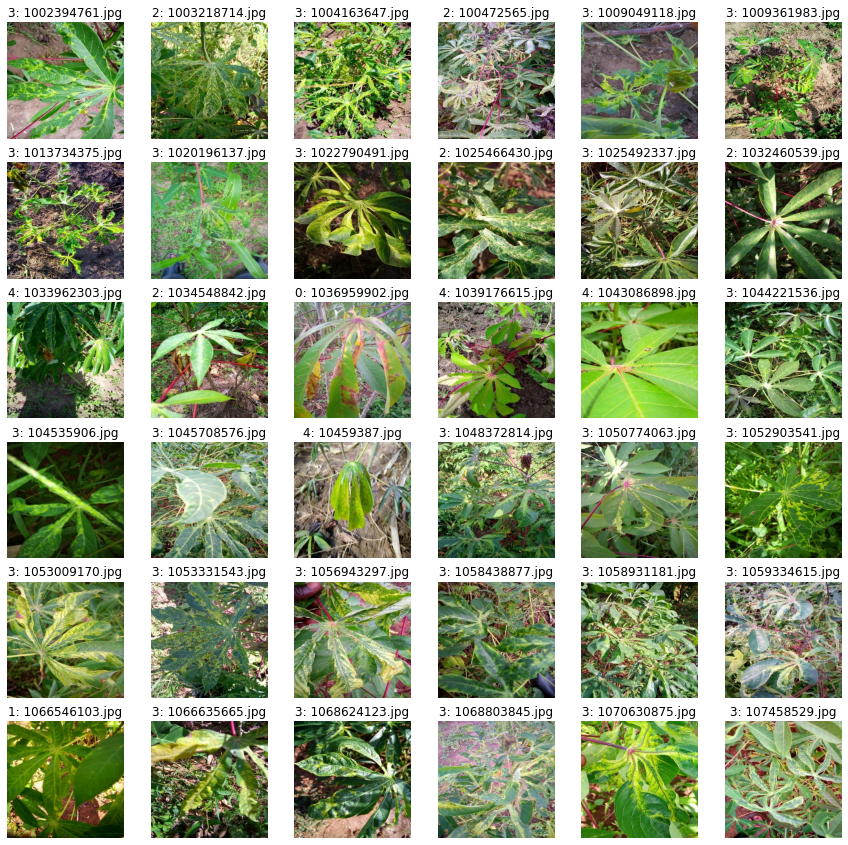

In [12]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('Id_train*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

# Complete set label distribution

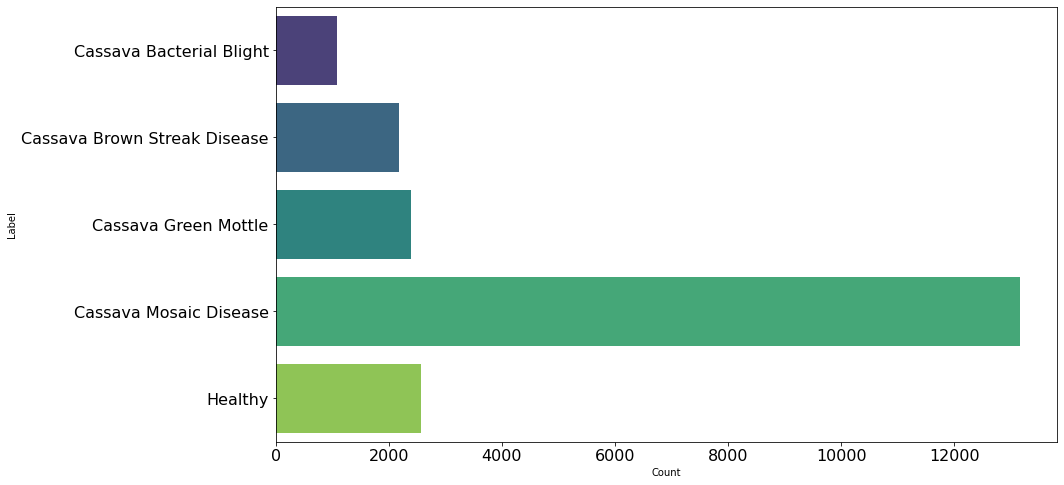

In [13]:
CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

label_count = train.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

## Labels distribution for each file

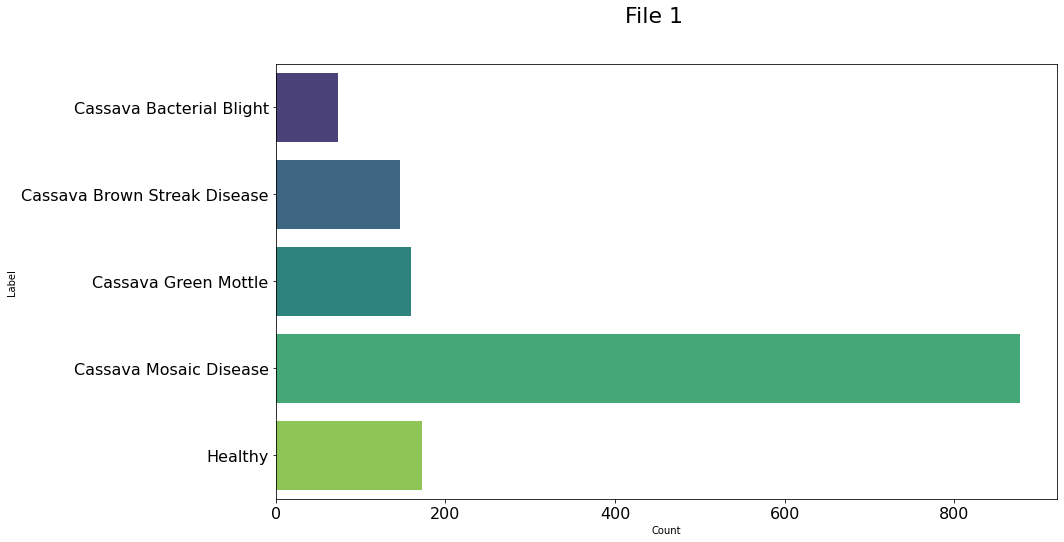

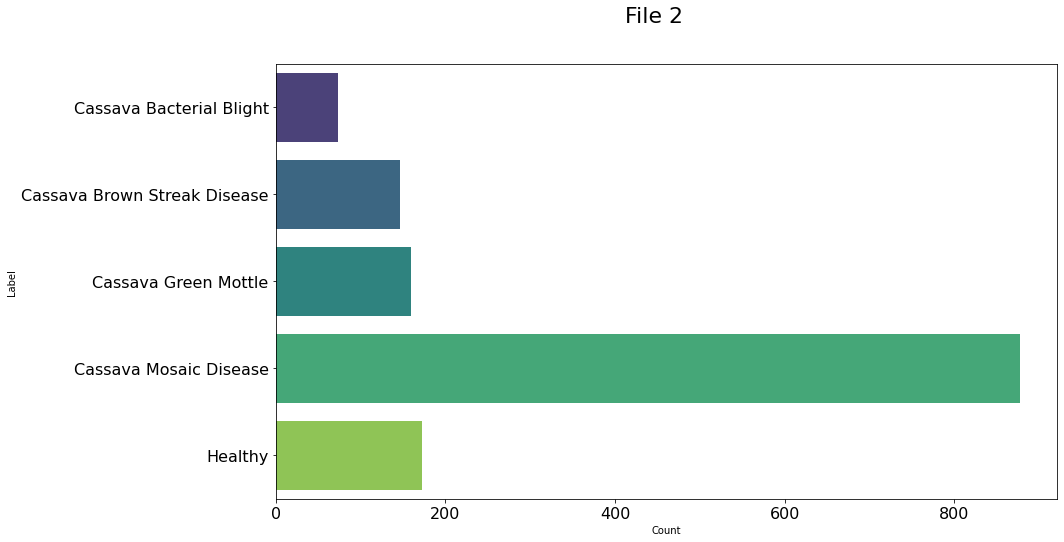

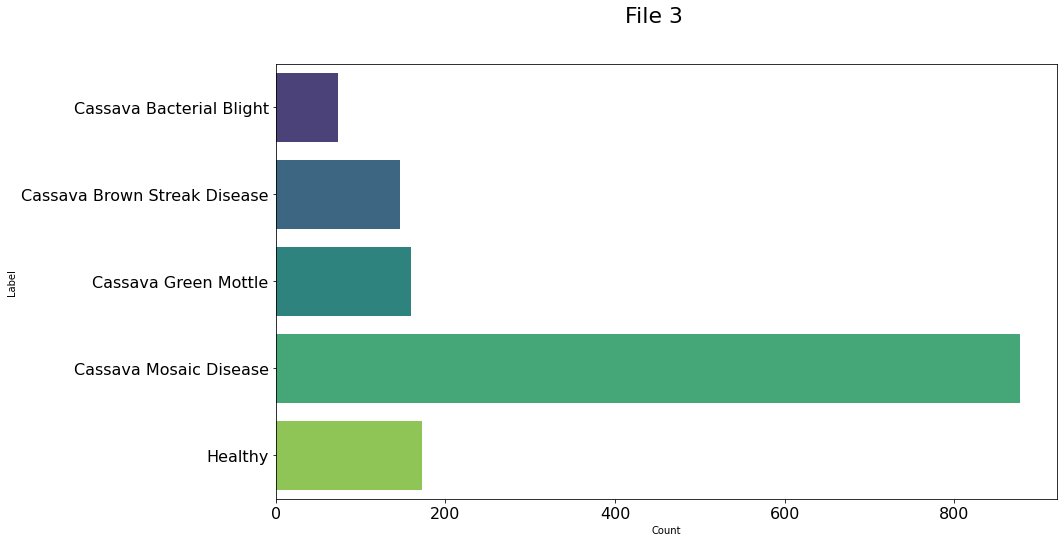

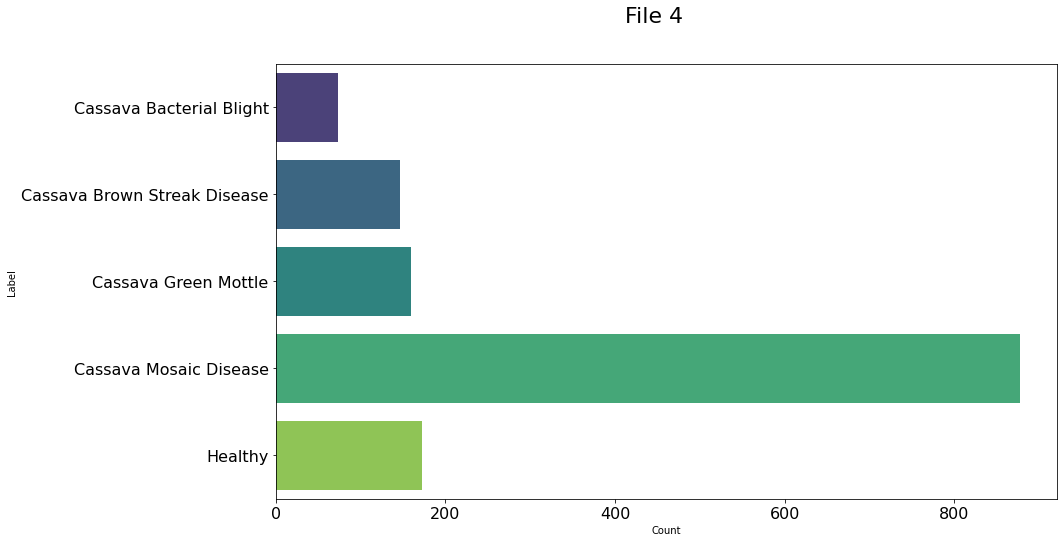

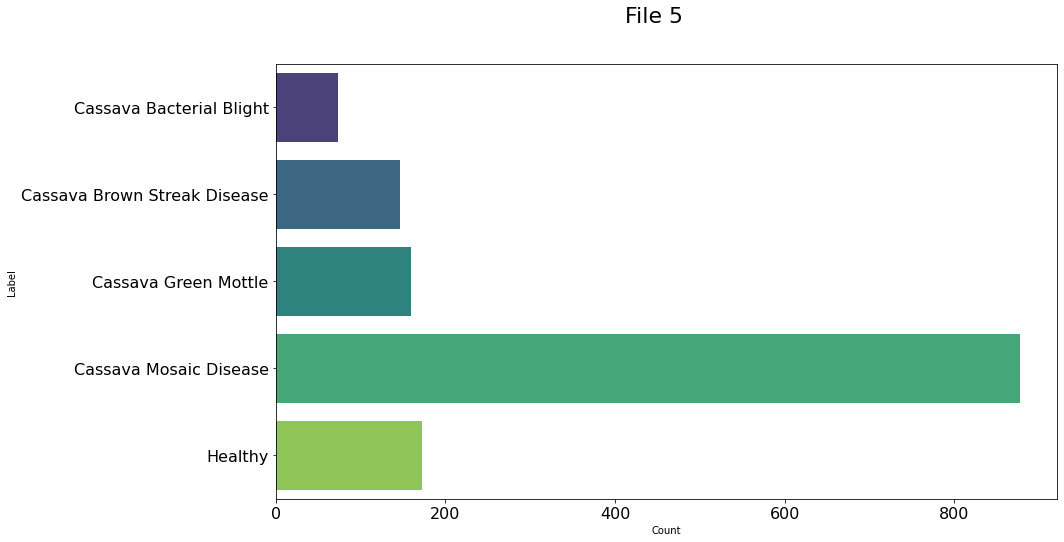

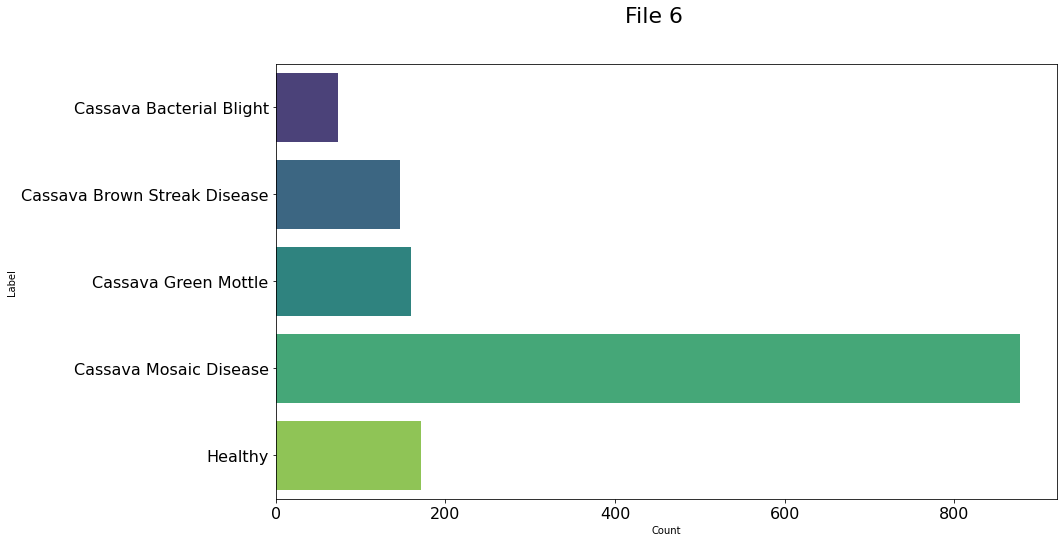

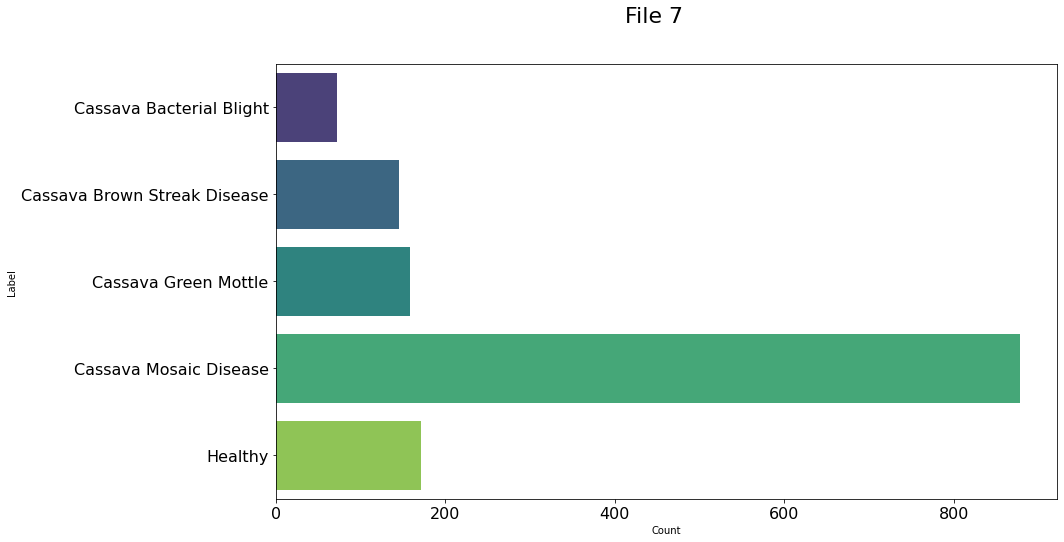

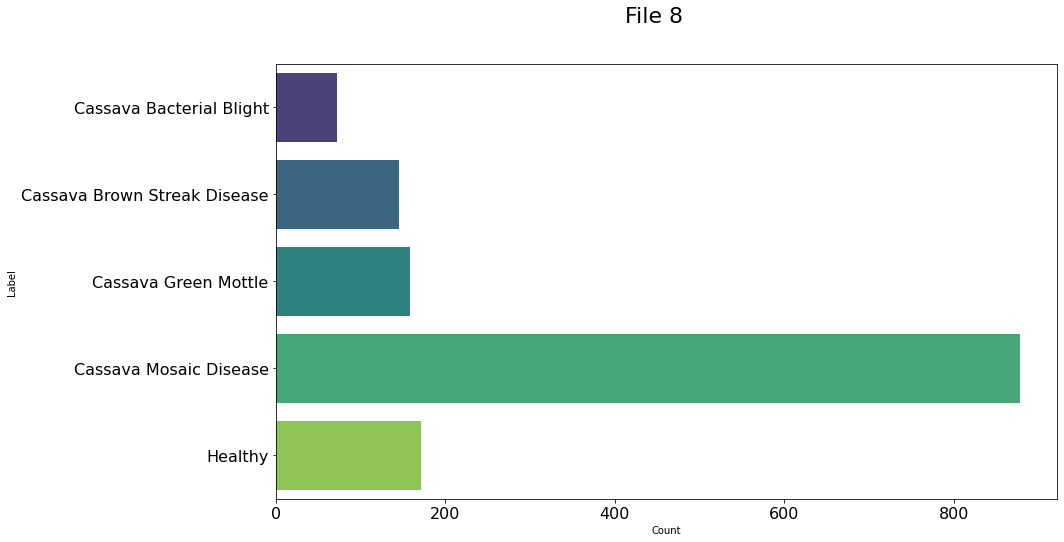

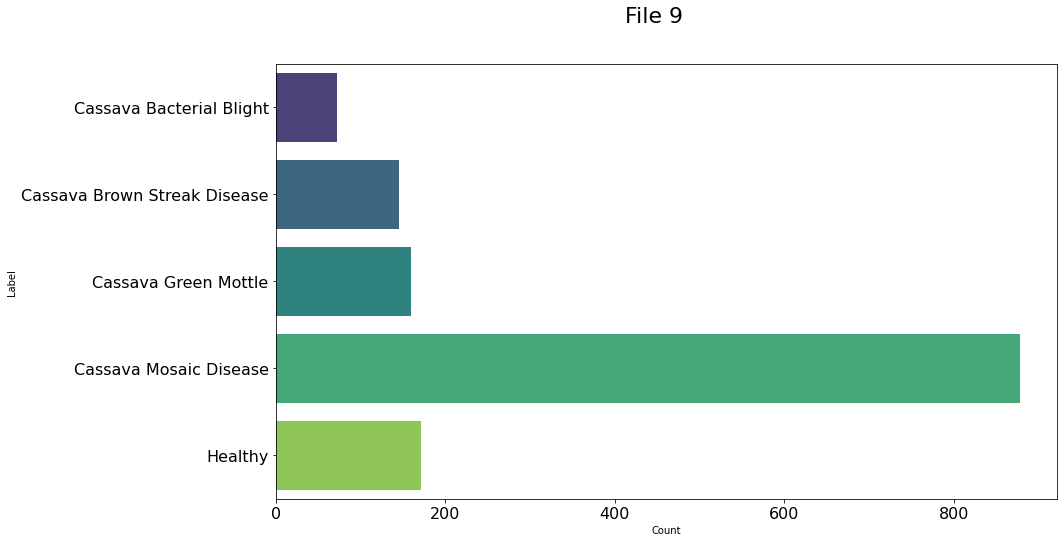

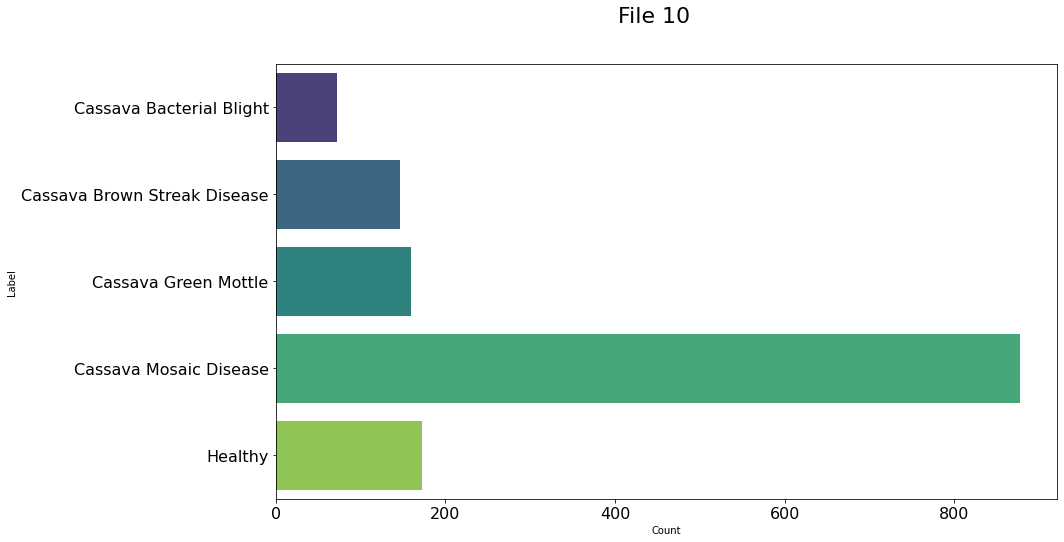

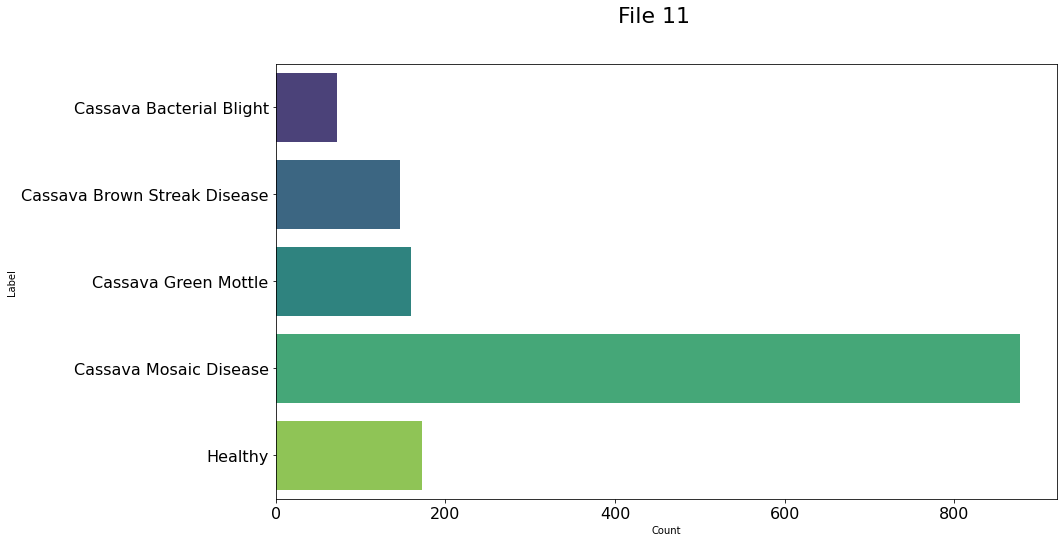

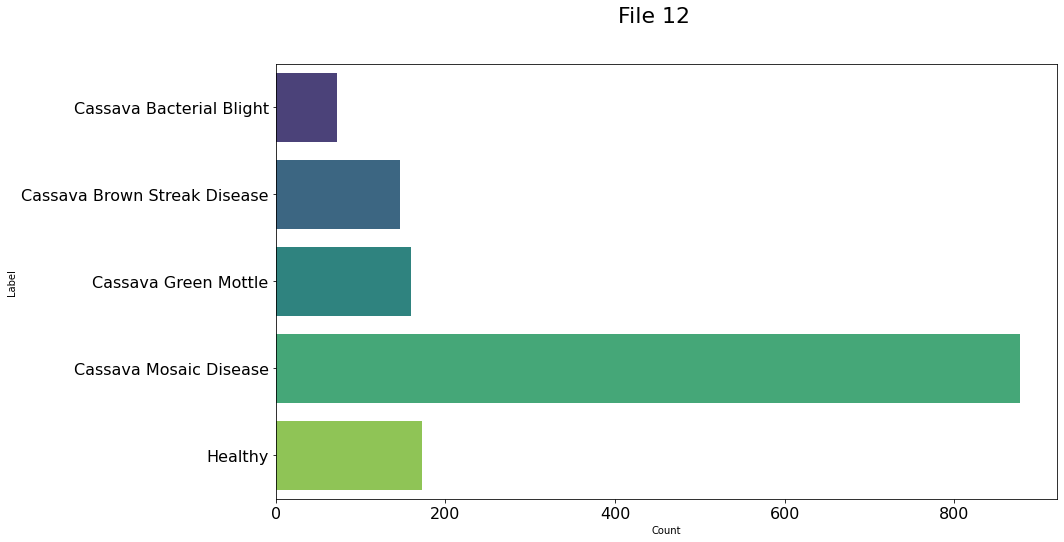

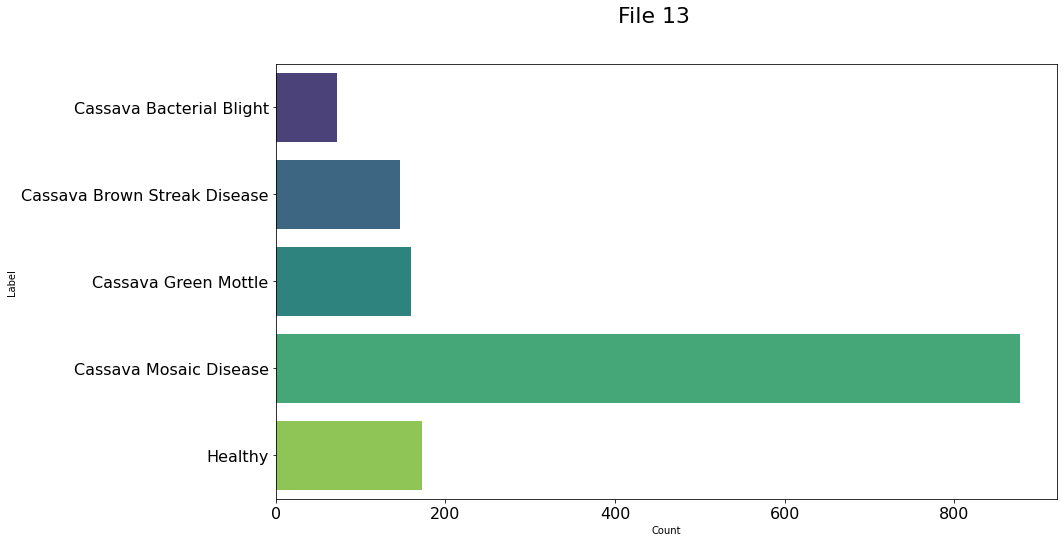

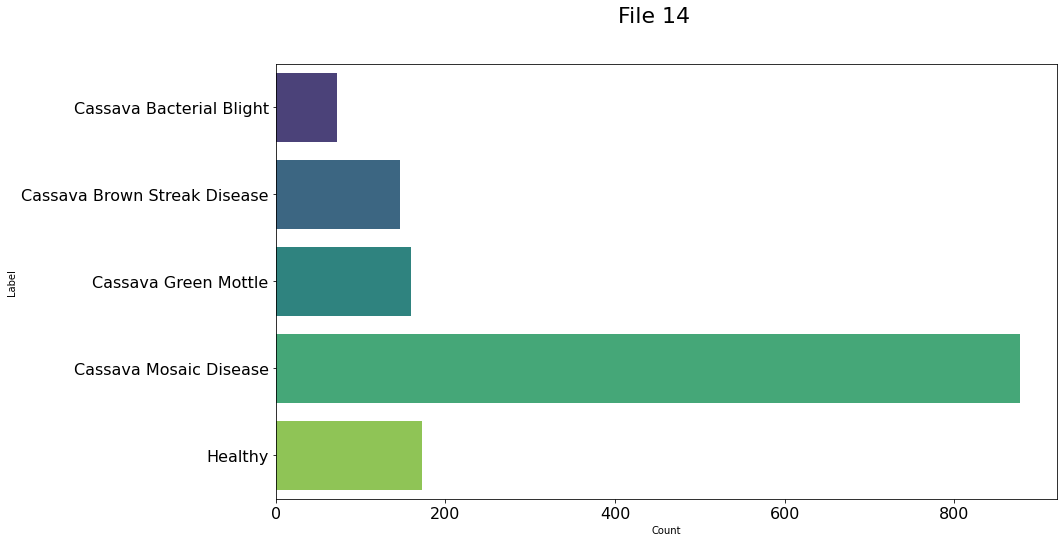

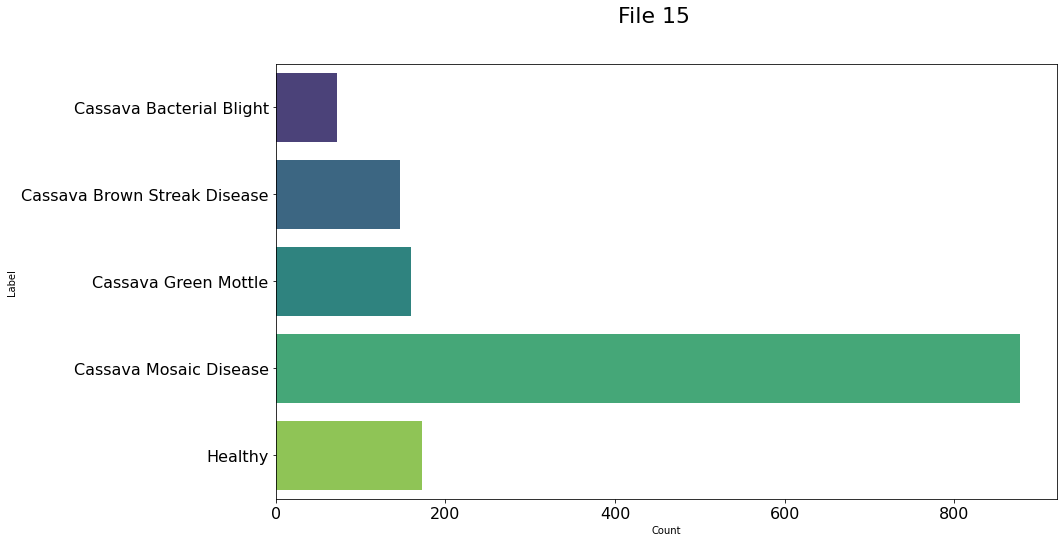

In [14]:
for fold_n in range(folds.n_splits):
    label_count = train[train['file'] == fold_n].groupby('label', as_index=False).count()
    label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
    label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.suptitle(f'File {fold_n+1}', fontsize=22)
    ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
    ax.tick_params(labelsize=16)

    plt.show()